In [ ]:
# from zipfile import ZipFile

# zippath="/content/drive/MyDrive/archive(2).zip"
# # loading the temp.zip and creating a zip object
# with ZipFile(zippath, 'r') as zObject:

#     # Extracting all the members of the zip
#     # into a specific location.
#     zObject.extractall(
#         path="/content/drive/MyDrive/")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics pandas opencv-python matplotlib scikit-learn tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import pandas as pd
import os
import ast
from sklearn.model_selection import train_test_split
from shutil import copyfile
from tqdm import tqdm

# Load annotations CSV
annotations = pd.read_csv('/content/drive/MyDrive/object_detection/annotations.csv')

# Create directories for YOLO format
os.makedirs('/content/drive/MyDrive/dataset/images/train', exist_ok=True)
os.makedirs('/content/drive/MyDrive/dataset/images/val', exist_ok=True)
os.makedirs('/content/drive/MyDrive/dataset/images/test', exist_ok=True)
os.makedirs('/content/drive/MyDrive/dataset/labels/train', exist_ok=True)
os.makedirs('/content/drive/MyDrive/dataset/labels/val', exist_ok=True)
os.makedirs('/content/drive/MyDrive/dataset/labels/test', exist_ok=True)

# Get unique image IDs
image_ids = annotations['image_id'].unique()

# Split data (70% train, 15% val, 15% test)
train_ids, test_ids = train_test_split(image_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(test_ids, test_size=0.5, random_state=42)

def convert_to_yolo_format(row, img_width=2560, img_height=2560):
    geometry = ast.literal_eval(row['geometry'])
    x_coords = [point[0] for point in geometry]
    y_coords = [point[1] for point in geometry]
    xmin, xmax = min(x_coords), max(x_coords)
    ymin, ymax = min(y_coords), max(y_coords)

    x_center = ((xmin + xmax) / 2) / img_width
    y_center = ((ymin + ymax) / 2) / img_height
    width = (xmax - xmin) / img_width
    height = (ymax - ymin) / img_height

    return f"0 {x_center} {y_center} {width} {height}"

# Helper function to save annotations and copy images
import os
from tqdm import tqdm
from shutil import copyfile

def save_annotations(image_set, subset):
    for img_id in tqdm(image_set):
        # Check if the image file exists
        src_img_path = f'/content/drive/MyDrive/object_detection/images/{img_id}'
        if not os.path.exists(src_img_path):
            print(f"Warning: Image {img_id} not found. Skipping...")
            continue  # Skip missing images

        # Process annotations
        img_annotations = annotations[annotations['image_id'] == img_id]
        yolo_annotations = img_annotations.apply(convert_to_yolo_format, axis=1).tolist()

        # Save YOLO annotations
        label_file_path = f'/content/drive/MyDrive/dataset/labels/{subset}/{img_id.replace(".jpg", ".txt")}'
        with open(label_file_path, 'w') as f:
            for ann in yolo_annotations:
                f.write(ann + '\n')

        # Copy image to the subset folder
        dst_img_path = f'/content/drive/MyDrive/dataset/images/{subset}/{img_id}'
        copyfile(src_img_path, dst_img_path)

# Generate YOLO formatted data
save_annotations(train_ids, 'train')
save_annotations(val_ids, 'val')
save_annotations(test_ids, 'test')


100%|██████████| 16/16 [00:00<00:00, 47.55it/s]


In [ ]:
from ultralytics import YOLO

# Load pre-trained YOLOv8 model (you can use yolov8n.pt or yolov8s.pt depending on resources)
yolo_model = YOLO('yolov8s.pt')

# Train the model on your dataset (adjust epochs as needed)
results = yolo_model.train(data="/content/drive/MyDrive/dataset.yaml",
                  epochs=40,
                  imgsz=640,
                  batch=16
                      )


Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/dataset.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

train: Scanning /content/drive/MyDrive/dataset/labels/train.cache... 72 images, 0 backgrounds, 0 corrupt: 100%|██████████| 72/72 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/dataset/labels/val.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]


Plotting labels to runs/detect/train9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train9
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      5.42G       3.01      4.611      1.731        313        640: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         15        528      0.023     0.0303    0.00637    0.00207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      5.42G       2.51       3.24      1.467        301        640: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         15        528      0.125      0.456      0.106     0.0479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      5.42G      1.617      1.278      1.051        333        640: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         15        528      0.702      0.855      0.849      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      5.42G      1.471     0.9174     0.9865        313        640: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         15        528      0.804      0.875       0.92      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      5.42G       1.39     0.8179     0.9441        314        640: 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         15        528      0.662       0.96      0.923      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      5.42G      1.364     0.7964     0.9396        419        640: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         15        528      0.633      0.965      0.929      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      5.42G      1.296       0.73     0.9316        375        640: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         15        528      0.763      0.949      0.952      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      5.42G      1.297     0.7606     0.9364        424        640: 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         15        528      0.877      0.905      0.941      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      5.42G      1.339     0.7685     0.9297        505        640: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         15        528      0.866       0.93      0.956      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      5.42G      1.232     0.6854     0.9129        275        640: 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         15        528      0.881      0.915      0.938      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      5.42G      1.226     0.6836     0.9123        329        640: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         15        528      0.903      0.864      0.938      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      5.42G      1.235     0.6554      0.918        450        640: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all         15        528      0.929      0.926      0.966      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      5.42G      1.212     0.6214     0.9085        408        640: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         15        528       0.94      0.955      0.976      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      5.42G      1.227     0.6262     0.9263        379        640: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         15        528      0.933      0.949       0.97      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      5.42G      1.194     0.6517     0.9106        398        640: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         15        528      0.959      0.923      0.974      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      5.42G      1.158     0.6011     0.8945        286        640: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         15        528      0.948      0.936      0.972      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      5.42G      1.143     0.5664     0.8968        325        640: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         15        528      0.945      0.932      0.977      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      5.42G      1.169     0.5726     0.9048        316        640: 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all         15        528      0.932      0.939      0.973      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      5.42G      1.177     0.5932     0.9069        331        640: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         15        528      0.948      0.941      0.976      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      5.42G      1.223     0.6067     0.9309        297        640: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         15        528      0.934      0.953      0.977      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      5.42G      1.196     0.5968     0.9106        237        640: 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         15        528      0.946      0.954       0.98      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      5.42G      1.134      0.566     0.8997        429        640: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all         15        528      0.951      0.958      0.984      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      5.42G       1.15     0.5862     0.8803        461        640: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         15        528      0.942      0.953      0.978      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      5.42G      1.124      0.547     0.8906        377        640: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         15        528      0.955      0.964      0.984      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      5.42G      1.105     0.5485     0.8822        355        640: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         15        528      0.951      0.954      0.979      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      5.42G      1.062      0.536     0.8823        377        640: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         15        528      0.949      0.957      0.981      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      5.42G      1.086     0.5295     0.8756        507        640: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         15        528      0.942      0.958      0.981      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      5.42G      1.079     0.5306     0.8901        380        640: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         15        528      0.942      0.977      0.986       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      5.42G      1.077     0.5165     0.8882        454        640: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         15        528      0.946      0.968      0.986      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      5.44G      1.073     0.5307     0.8875        297        640: 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all         15        528      0.951      0.961      0.986      0.605


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      5.44G      1.019     0.4978     0.8808        256        640: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         15        528      0.955      0.954      0.984      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      5.44G      1.031     0.4899     0.8889        315        640: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         15        528       0.97      0.971      0.988      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      5.48G      1.024     0.4861     0.8727        239        640: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         15        528      0.973      0.972      0.989      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      5.48G      1.005     0.4681     0.8759        249        640: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         15        528      0.977      0.971      0.989      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      5.48G     0.9992     0.4625     0.8697        264        640: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         15        528      0.975      0.968      0.989      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      5.48G      1.015     0.4589      0.877        224        640: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         15        528      0.972      0.972      0.989       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      5.51G      1.002     0.4632     0.8776        206        640: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         15        528      0.962      0.977      0.988      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      5.51G     0.9897     0.4638     0.8862        213        640: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         15        528      0.968      0.981      0.989      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      5.51G      0.979     0.4488     0.8702        229        640: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         15        528      0.967      0.979      0.989      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      5.55G      1.009     0.4662     0.8684        168        640: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         15        528      0.972      0.976       0.99      0.631



40 epochs completed in 0.040 hours.
Optimizer stripped from runs/detect/train9/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train9/weights/best.pt, 22.5MB

Validating runs/detect/train9/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


                   all         15        528      0.946      0.968      0.986      0.641
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train9


In [ ]:
import torch

def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    :param box1: [x_min, y_min, x_max, y_max] for box 1
    :param box2: [x_min, y_min, x_max, y_max] for box 2
    :return: IoU value
    """
    # Ensure inputs are tensors
    box1 = torch.tensor(box1, dtype=torch.float32)
    box2 = torch.tensor(box2, dtype=torch.float32)[0]
    # print(box1)
    # print(box2)
    # Calculate intersection coordinates
    x1 = torch.max(box1[0], box2[0])
    y1 = torch.max(box1[1], box2[1])
    x2 = torch.min(box1[2], box2[2])
    y2 = torch.min(box1[3], box2[3])

    # Compute intersection area
    intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)

    # Compute union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection

    # Compute IoU
    iou = intersection / union if union > 0 else torch.tensor(0.0)
    return iou.item()  # Convert tensor to Python float for readability


In [ ]:
import os
import ast

# Path to test labels and predictions
test_labels_path = '/content/drive/MyDrive/dataset/labels/test'
test_images_path = '/content/drive/MyDrive/dataset/images/test'

# Load ground truth labels
def load_ground_truth(image_id, labels_path):
    """
    Load ground truth bounding boxes for a given image.
    :param image_id: Image filename (e.g., 'image.jpg')
    :param labels_path: Path to the folder containing label files
    :return: List of bounding boxes in [x_min, y_min, x_max, y_max] format
    """
    label_file = os.path.join(labels_path, image_id.replace('.jpg', '.txt'))
    if not os.path.exists(label_file):
        print(f"Warning: Label file {label_file} not found.")
        return []

    with open(label_file, 'r') as f:
        lines = f.readlines()
        boxes = []
        for line in lines:
            _, x_center, y_center, width, height = map(float, line.strip().split())
            # Convert YOLO format to [x_min, y_min, x_max, y_max]
            x_min = (x_center - width / 2) * 2560
            y_min = (y_center - height / 2) * 2560
            x_max = (x_center + width / 2) * 2560
            y_max = (y_center + height / 2) * 2560
            boxes.append([x_min, y_min, x_max, y_max])
            # print(x_min,y_max)
        return boxes


# Run predictions on test images
results = yolo_model.predict(source=test_images_path)
test_labels_path = '/content/drive/MyDrive/dataset/labels/test'
# Compute IoU for each image
ious = []
for result in results:
    image_id = os.path.basename(result.path)
    # print(image_id)
    # Get ground truth boxes
    ground_truth_boxes = load_ground_truth(image_id,test_labels_path)
    # print(result[0])
    # Get predicted boxes in [x_min, y_min, x_max, y_max] format
    predicted_boxes = [box.xyxy for box in result.boxes]

    # Compute IoU for each pair of ground truth and predicted boxes
    for gt_box in ground_truth_boxes:
        for pred_box in predicted_boxes:
            gt_box=torch.tensor(gt_box, dtype=torch.float32)
            # print(gt_box,pred_box)

            iou = calculate_iou(gt_box, pred_box)
            ious.append(iou)

# Print average IoU across all images
yolo_average_iou = sum(ious) / len(ious) if ious else 0
print(f"Average IoU: {yolo_average_iou:.9f}")



image 1/16 /content/drive/MyDrive/dataset/images/test/12210ad7-83f8-4b54-bb4b-e93f8ff6ac1f.jpg: 640x640 26 Airplanes, 16.4ms
image 2/16 /content/drive/MyDrive/dataset/images/test/22457f2e-a740-4719-9512-056749695281.jpg: 640x640 12 Airplanes, 16.3ms
image 3/16 /content/drive/MyDrive/dataset/images/test/2314c1b5-ec8f-4212-b42f-43365a13fd20.jpg: 640x640 25 Airplanes, 16.4ms
image 4/16 /content/drive/MyDrive/dataset/images/test/4a0821b7-3689-4b0e-9397-389254ea9a32.jpg: 640x640 39 Airplanes, 16.3ms
image 5/16 /content/drive/MyDrive/dataset/images/test/4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg: 640x640 20 Airplanes, 16.3ms
image 6/16 /content/drive/MyDrive/dataset/images/test/5bb8ab95-f141-43ca-a722-a1937d9d5a72.jpg: 640x640 6 Airplanes, 16.3ms
image 7/16 /content/drive/MyDrive/dataset/images/test/70332141-fcd3-4e2e-89c7-d50cbc03c25f.jpg: 640x640 40 Airplanes, 16.3ms
image 8/16 /content/drive/MyDrive/dataset/images/test/77f7b57f-5cf2-424d-a952-9847b3c3f35e.jpg: 640x640 37 Airplanes, 16.3ms


<ipython-input-74-7c99144ea22c>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  box1 = torch.tensor(box1, dtype=torch.float32)
<ipython-input-74-7c99144ea22c>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  box2 = torch.tensor(box2, dtype=torch.float32)[0]
<ipython-input-75-610ef058d1d0>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_box=torch.tensor(gt_box, dtype=torch.float32)


Average IoU: 0.976630567


In [ ]:
metrics = yolo_model.val(data="/content/drive/MyDrive/dataset.yaml")

yolo_mAP50_95= metrics.box.map
yolo_mAP50= metrics.box.map50
# print(f"IoU: {metrics.box.iou:.3f}")
yolo_Precision= metrics.box.p
yolo_Recall= metrics.box.r
yolo_F1_score= metrics.box.f1

print(f"mAP50-95: {metrics.box.map:.3f}")
print(f"mAP50: {metrics.box.map50:.3f}")
# print(f"IoU: {metrics.box.iou:.3f}")
print(f"Precision: {metrics.box.p}")
print(f"Recall: {metrics.box.r}")
print(f"F1-score: {metrics.box.f1}")


Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/drive/MyDrive/dataset/labels/val.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


                   all         15        528      0.947      0.968      0.986      0.643
Speed: 0.3ms preprocess, 11.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train92
mAP50-95: 0.643
mAP50: 0.986
Precision: [    0.94654]
Recall: [     0.9678]
F1-score: [    0.95705]



image 1/1 /content/drive/MyDrive/object_detection/extras/022f91f0-1434-401f-a11b-e315b7068100.jpg: 640x640 27 Airplanes, 16.3ms
Speed: 3.7ms preprocess, 16.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


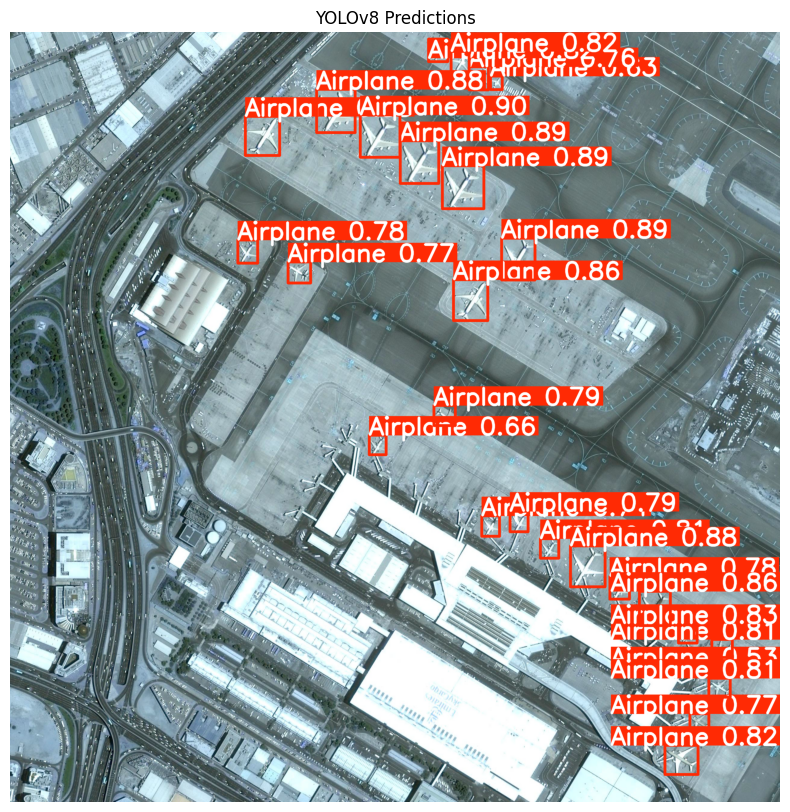

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image

# Load your trained YOLOv8 model
# model = YOLO('yolov8s.pt')  # Replace with your trained model if needed

# Path to a sample image
image_path = '/content/drive/MyDrive/object_detection/extras/022f91f0-1434-401f-a11b-e315b7068100.jpg'

# Run inference on the image
results = model.predict(source=image_path, conf=0.45)  # Adjust confidence threshold if needed

# Get the annotated image (NumPy array)
annotated_image = results[0].plot()  # YOLOv8's built-in method for visualization

# Convert annotated image to PIL format for display in Colab
# annotated_image_pil = Image.fromarray(annotated_image)

# Display the annotated image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
# plt.imshow(image_path)
plt.axis('off')
plt.title("YOLOv8 Predictions")
plt.show()


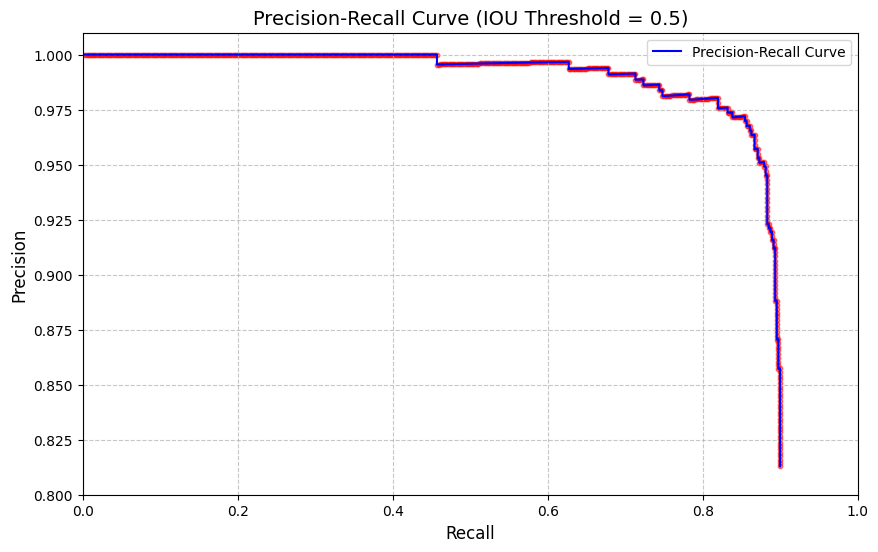

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# First, fix the IoU calculation function
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    Corrected version without tensor indexing bug.
    """
    box1 = torch.tensor(box1, dtype=torch.float32)
    box2 = torch.tensor(box2, dtype=torch.float32)

    x1 = torch.max(box1[0], box2[0])
    y1 = torch.max(box1[1], box2[1])
    x2 = torch.min(box1[2], box2[2])
    y2 = torch.min(box1[3], box2[3])

    intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection

    iou = intersection / union if union > 0 else torch.tensor(0.0)
    return iou.item()

# Data collection for PR curve
all_confidences = []
all_tp = []
all_fp = []
total_gt = 0

for result in results:
    image_id = os.path.basename(result.path)
    ground_truth_boxes = load_ground_truth(image_id, test_labels_path)
    total_gt += len(ground_truth_boxes)

    if len(result.boxes) == 0:
        continue  # Skip if no predictions

    # Sort predictions by confidence descending
    pred_boxes = result.boxes
    confidences = pred_boxes.conf
    sorted_indices = torch.argsort(confidences, descending=True)

    gt_matched = [False] * len(ground_truth_boxes)

    for idx in sorted_indices:
        box = pred_boxes[idx]
        confidence = box.conf.item()
        pred_box = box.xyxy[0].tolist()

        max_iou = 0.0
        best_gt_idx = -1

        for i, gt_box in enumerate(ground_truth_boxes):
            iou = calculate_iou(pred_box, gt_box)
            if iou > max_iou:
                max_iou = iou
                best_gt_idx = i

        if max_iou >= 0.5 and best_gt_idx != -1 and not gt_matched[best_gt_idx]:
            all_tp.append(1)
            all_fp.append(0)
            gt_matched[best_gt_idx] = True
        else:
            all_tp.append(0)
            all_fp.append(1)

        all_confidences.append(confidence)

# Sort all predictions by confidence descending
sorted_indices = np.argsort(-np.array(all_confidences))
all_confidences = np.array(all_confidences)[sorted_indices]
all_tp = np.array(all_tp)[sorted_indices]
all_fp = np.array(all_fp)[sorted_indices]

# Calculate cumulative sums
cum_tp = np.cumsum(all_tp)
cum_fp = np.cumsum(all_fp)

# Compute precision and recall
precision = cum_tp / (cum_tp + cum_fp + 1e-6)  # Avoid division by zero
recall = cum_tp / total_gt

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='Precision-Recall Curve', color='blue')
plt.scatter(recall, precision, s=10, color='red', alpha=0.5)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve (IOU Threshold = 0.5)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xlim(0, 1)
plt.ylim(0.8, 1.01)
plt.show()


# Faster RCNN


In [ ]:
import pandas as pd
import os
import ast
import json
from sklearn.model_selection import train_test_split
from shutil import copyfile
from tqdm import tqdm

# Load annotations CSV
annotations = pd.read_csv('/content/drive/MyDrive/object_detection/annotations.csv')

# Create directories for Faster R-CNN format
os.makedirs('/content/drive/MyDrive/faster_rcnn/images/train', exist_ok=True)
os.makedirs('/content/drive/MyDrive/faster_rcnn/images/val', exist_ok=True)
os.makedirs('/content/drive/MyDrive/faster_rcnn/images/test', exist_ok=True)
os.makedirs('/content/drive/MyDrive/faster_rcnn/annotations/train', exist_ok=True)
os.makedirs('/content/drive/MyDrive/faster_rcnn/annotations/val', exist_ok=True)
os.makedirs('/content/drive/MyDrive/faster_rcnn/annotations/test', exist_ok=True)

# Get unique image IDs
image_ids = annotations['image_id'].unique()

# Split data (70% train, 15% val, 15% test)
train_ids, test_ids = train_test_split(image_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(test_ids, test_size=0.5, random_state=42)

def convert_to_faster_rcnn_format(row):
    geometry = ast.literal_eval(row['geometry'])
    x_coords = [point[0] for point in geometry]
    y_coords = [point[1] for point in geometry]
    xmin, xmax = min(x_coords), max(x_coords)
    ymin, ymax = min(y_coords), max(y_coords)

    return {
        "class": row['class'],
        "bbox": [xmin, ymin, xmax, ymax]
    }

def save_annotations(image_set, subset):
    for img_id in tqdm(image_set):
        # Check if the image file exists
        src_img_path = f'/content/drive/MyDrive/object_detection/images/{img_id}'
        if not os.path.exists(src_img_path):
            print(f"Warning: Image {img_id} not found. Skipping...")
            continue  # Skip missing images

        # Process annotations
        img_annotations = annotations[annotations['image_id'] == img_id]
        faster_rcnn_annotations = img_annotations.apply(convert_to_faster_rcnn_format, axis=1).tolist()

        # Save annotations in JSON format
        annotation_file_path = f'/content/drive/MyDrive/faster_rcnn/annotations/{subset}/{img_id.replace(".jpg", ".json")}'
        with open(annotation_file_path, 'w') as f:
            json.dump({"image": img_id, "annotations": faster_rcnn_annotations}, f)

        # Copy image to the subset folder
        dst_img_path = f'/content/drive/MyDrive/faster_rcnn/images/{subset}/{img_id}'
        copyfile(src_img_path, dst_img_path)

# Generate Faster R-CNN formatted data
save_annotations(train_ids, 'train')
save_annotations(val_ids, 'val')
save_annotations(test_ids, 'test')


100%|██████████| 16/16 [00:00<00:00, 42.18it/s]


In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import numpy as np
import os, ast, json, cv2, time
from sklearn.model_selection import train_test_split
from shutil import copyfile
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
class AircraftDataset(Dataset):
    def __init__(self, image_dir, annotation_dir):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.image_files = os.listdir(image_dir)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        annotation_path = os.path.join(self.annotation_dir, img_name.replace('.jpg', '.json'))

        image = Image.open(img_path).convert("RGB")
        image_tensor = F.to_tensor(image)

        with open(annotation_path) as f:
            annotations = json.load(f)

        boxes = torch.tensor([ann['bbox'] for ann in annotations['annotations']], dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)  # Airplane class label: 1

        target = {"boxes": boxes, "labels": labels}
        return image_tensor, target

    def __len__(self):
        return len(self.image_files)


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = AircraftDataset('/content/drive/MyDrive/faster_rcnn/images/train',
                                '/content/drive/MyDrive/faster_rcnn/annotations/train')
val_dataset = AircraftDataset('/content/drive/MyDrive/faster_rcnn/images/val',
                              '/content/drive/MyDrive/faster_rcnn/annotations/val')

train_loader = DataLoader(train_dataset, batch_size=2,
                          shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1,
                        shuffle=False, collate_fn=collate_fn)


In [ ]:
frcnn_model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # background + airplane

in_features = frcnn_model.roi_heads.box_predictor.cls_score.in_features
frcnn_model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features,
                                                                                           num_classes)
frcnn_model.to(device)
optimizer = torch.optim.Adam(frcnn_model.parameters(), lr=1e-4)

num_epochs = 10

for epoch in range(num_epochs):
    frcnn_model.train()
    epoch_loss = 0

    for images, targets in tqdm(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = frcnn_model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 66.5MB/s]
100%|██████████| 36/36 [00:25<00:00,  1.44it/s]


Epoch 1/10, Loss: 37.2328


100%|██████████| 36/36 [00:24<00:00,  1.49it/s]


Epoch 2/10, Loss: 21.5799


100%|██████████| 36/36 [00:24<00:00,  1.48it/s]


Epoch 3/10, Loss: 17.5253


100%|██████████| 36/36 [00:24<00:00,  1.49it/s]


Epoch 4/10, Loss: 15.0198


100%|██████████| 36/36 [00:24<00:00,  1.48it/s]


Epoch 5/10, Loss: 14.8283


100%|██████████| 36/36 [00:24<00:00,  1.49it/s]


Epoch 6/10, Loss: 13.8446


100%|██████████| 36/36 [00:24<00:00,  1.47it/s]


Epoch 7/10, Loss: 12.5408


100%|██████████| 36/36 [00:24<00:00,  1.49it/s]


Epoch 8/10, Loss: 11.1647


100%|██████████| 36/36 [00:24<00:00,  1.49it/s]


Epoch 9/10, Loss: 9.8340


100%|██████████| 36/36 [00:24<00:00,  1.49it/s]

Epoch 10/10, Loss: 9.4620


In [ ]:
def calculate_iou(box1, box2):
    # Calculate intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate areas
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate IoU
    union = box1_area + box2_area - intersection
    iou = intersection / union if union > 0 else 0

    return iou

def calculate_metrics(predictions, targets, iou_threshold=0.5):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    total_iou = 0
    total_matches = 0

    for pred, target in zip(predictions, targets):
        pred_boxes = pred['boxes'].cpu().numpy()
        pred_scores = pred['scores'].cpu().numpy()
        target_boxes = target['boxes'].cpu().numpy()

        # Only consider predictions with score > 0.5
        pred_boxes = pred_boxes[pred_scores > 0.5]

        # Match predictions to targets
        matched_targets = set()

        for pred_box in pred_boxes:
            best_iou = 0
            best_target_idx = -1

            for i, target_box in enumerate(target_boxes):
                if i in matched_targets:
                    continue

                iou = calculate_iou(pred_box, target_box)
                if iou > best_iou:
                    best_iou = iou
                    best_target_idx = i

            if best_iou > iou_threshold:
                true_positives += 1
                matched_targets.add(best_target_idx)
                total_iou += best_iou
                total_matches += 1
            else:
                false_positives += 1

        false_negatives += len(target_boxes) - len(matched_targets)

    # Calculate metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate average IoU
    avg_iou = total_iou / total_matches if total_matches > 0 else 0

    # Calculate mAP (simplified)
    map50 = precision * recall  # This is a simplified approximation

    return precision, recall, f1, map50, avg_iou

def evaluate_faster_rcnn(model, val_dataset):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    model.eval()

    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False,
                           collate_fn=lambda x: tuple(zip(*x)))

    # Metrics
    all_predictions = []
    all_targets = []
    inference_times = []

    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc="Evaluating Faster R-CNN"):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Measure inference time
            start_time = time.time()
            outputs = model(images)
            end_time = time.time()
            inference_times.append(end_time - start_time)

            # Store predictions and targets for metric calculation
            all_predictions.extend(outputs)
            all_targets.extend(targets)

    # Calculate metrics
    precision, recall, f1, map50, avg_iou = calculate_metrics(all_predictions, all_targets)
    avg_inference_time = sum(inference_times) / len(inference_times)

    print(f"Faster R-CNN mAP@50: {map50:.4f}")
    print(f"Faster R-CNN Precision: {precision:.4f}")
    print(f"Faster R-CNN Recall: {recall:.4f}")
    print(f"Faster R-CNN F1-score: {f1:.4f}")
    print(f"Faster R-CNN Average IoU: {avg_iou:.4f}")
    print(f"Faster R-CNN Average Inference Time: {avg_inference_time*1000:.2f} ms per image")

    return precision, recall, f1, map50, avg_iou, avg_inference_time

In [ ]:
fast_precision, fast_recall, fast_f1_score, fast_map50, fast_avg_iou, fast_avg_inf_time = evaluate_faster_rcnn(model=model,
                       val_dataset=val_dataset)


Evaluating Faster R-CNN: 100%|██████████| 15/15 [00:03<00:00,  4.89it/s]


Faster R-CNN mAP@50: 0.9363
Faster R-CNN Precision: 0.9732
Faster R-CNN Recall: 0.9621
Faster R-CNN F1-score: 0.9676
Faster R-CNN Average IoU: 0.8158
Faster R-CNN Average Inference Time: 84.37 ms per image


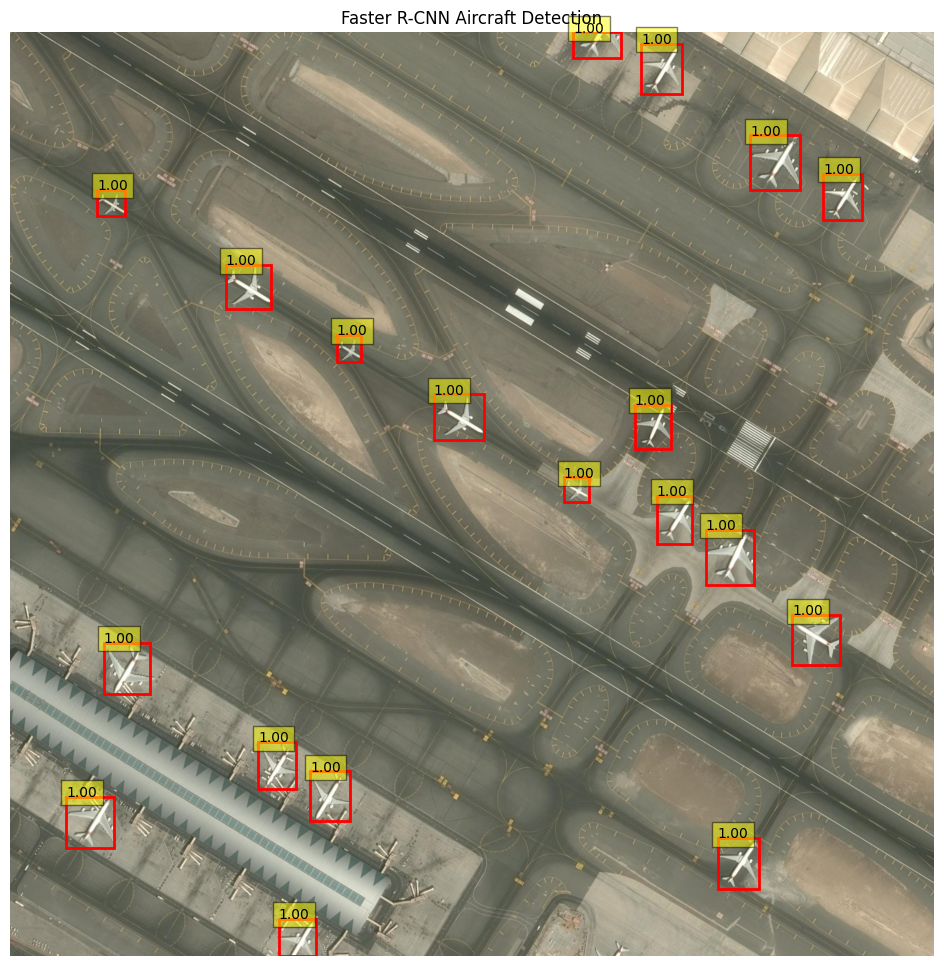

In [ ]:
def visualize_faster_rcnn(model,image_path):
    model.eval()
    image=cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)
    tensor_image=F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction=model(tensor_image)[0]

    plt.figure(figsize=(12,12))
    plt.imshow(image)

    for box,scr in zip(prediction['boxes'].cpu(),prediction['scores'].cpu()):
      if scr>0.5:
          x1,y1,x2,y2=box.numpy().astype(int)
          plt.gca().add_patch(plt.Rectangle((x1,y1),x2-x1,y2-y1,
                                            edgecolor='red',linewidth=2,
                                            fill=False))
          plt.text(x1,y1,f'{scr:.2f}',bbox=dict(facecolor='yellow',alpha=0.5))

    plt.axis('off')
    plt.title('Faster R-CNN Aircraft Detection')
    plt.show()

# Example usage:
visualize_faster_rcnn(model,'/content/drive/MyDrive/faster_rcnn/images/test/2314c1b5-ec8f-4212-b42f-43365a13fd20.jpg')



In [ ]:
def evaluate_model(model, dataloader, iou_threshold=0.5):
    model.eval()
    all_preds = []  # Confidence scores for predictions
    all_targets = []  # 1 = true positive, 0 = false positive

    def compute_iou(box1, box2):
        """
        Compute Intersection over Union (IoU) between two bounding boxes.
        Args:
            box1: [xmin, ymin, xmax, ymax]
            box2: [xmin, ymin, xmax, ymax]
        Returns:
            IoU value (float)
        """
        # Calculate intersection coordinates
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])

        # Compute intersection area
        intersection = max(0, x2 - x1) * max(0, y2 - y1)

        # Compute areas of both boxes
        area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

        # Compute union area
        union = area_box1 + area_box2 - intersection

        return intersection / union if union > 0 else 0.0  # Always return float

    with torch.no_grad():
        for images, targets in tqdm(dataloader):
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output["boxes"].cpu().numpy()
                pred_scores = output["scores"].cpu().numpy()
                gt_boxes = targets[i]["boxes"].cpu().numpy()

                matched_gt = set()

                for j, pred_box in enumerate(pred_boxes):
                    best_iou = 0.0  # Initialize as float
                    best_gt_idx = -1

                    for k, gt_box in enumerate(gt_boxes):
                        iou = compute_iou(pred_box, gt_box)  # Now returns float
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = k

                    if best_iou >= iou_threshold and best_gt_idx not in matched_gt:
                        all_targets.append(1)
                        matched_gt.add(best_gt_idx)
                    else:
                        all_targets.append(0)

                    all_preds.append(pred_scores[j])

    # Ensure consistent lengths
    assert len(all_preds) == len(all_targets), "Mismatch in prediction/ground truth counts"

    precisions, recalls, _ = precision_recall_curve(all_targets, all_preds)
    ap = average_precision_score(all_targets, all_preds)

    return precisions, recalls


100%|██████████| 15/15 [00:04<00:00,  3.07it/s]


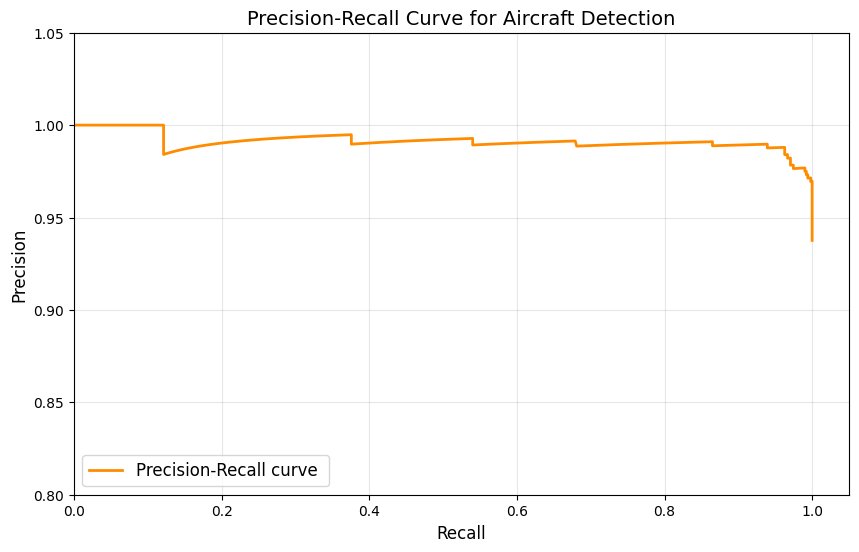

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def plot_precision_recall_curve(precisions, recalls):
    plt.figure(figsize=(10, 6))
    plt.plot(recalls, precisions, color='darkorange', lw=2,
             label=f'Precision-Recall curve ')

    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve for Aircraft Detection', fontsize=14)
    plt.xlim([0.0, 1.05])
    plt.ylim([0.8, 1.05])
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower left', fontsize=12)
    plt.show()

# After evaluating your model
precisions, recalls = evaluate_model(model, val_loader)
# average_precision = average_precision_score(all_targets, all_preds)

plot_precision_recall_curve(precisions, recalls)


Comparison of Evaluation Metrics:
      Metric  Faster R-CNN      YOLO
0   mAP@0.50      0.936317  0.986178
1  Precision      0.973180  0.946543
2     Recall      0.962121  0.967803
3   F1-Score      0.967619  0.957055
4        IoU      0.815804  0.976631


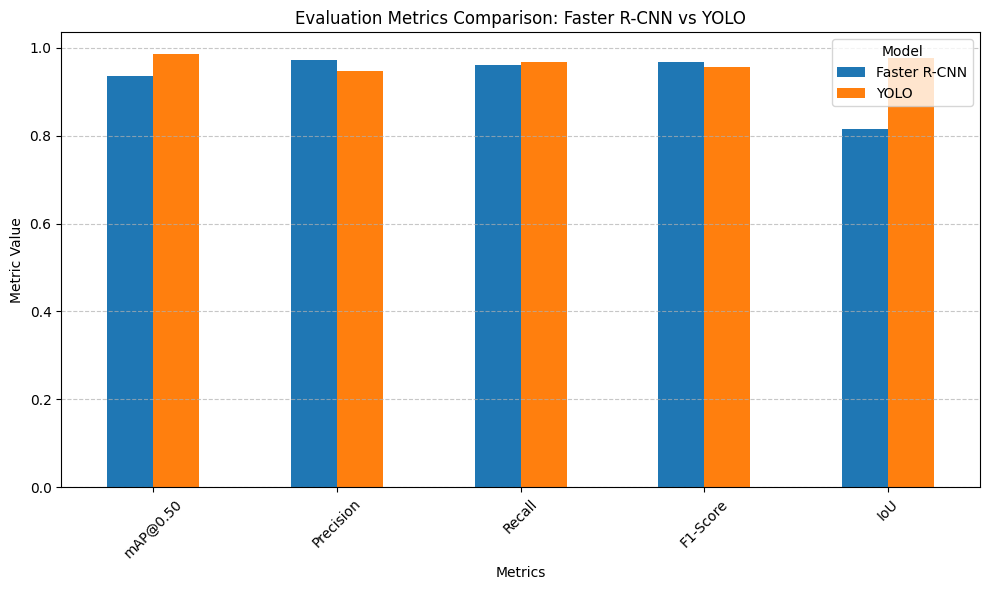

In [ ]:
import pandas as pd

# Define evaluation metrics for Faster R-CNN and YOLO
metrics = {
    "Metric": ["mAP@0.50", "Precision", "Recall", "F1-Score", "IoU"],
    "Faster R-CNN": [fast_map50,fast_precision, fast_recall, fast_f1_score,  fast_avg_iou],  # Example values for Faster R-CNN
    "YOLO": [yolo_mAP50,yolo_Precision[0],yolo_Recall[0],yolo_F1_score[0],yolo_average_iou]           # Example values for YOLO
}

# Create a DataFrame
df = pd.DataFrame(metrics)

# Print the table
print("Comparison of Evaluation Metrics:")
print(df)

# Optional: Save the table to a CSV file
df.to_csv("model_comparison.csv", index=False)

# Plot the comparison using a bar chart
import matplotlib.pyplot as plt

# Set up the plot
df.set_index("Metric").plot(kind="bar", figsize=(10, 6), rot=45)
plt.title("Evaluation Metrics Comparison: Faster R-CNN vs YOLO")
plt.ylabel("Metric Value")
plt.xlabel("Metrics")
plt.legend(title="Model")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()
